In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import yaml
import math
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    RandomHorizontalFlip,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from datasets import load_dataset
from diffusers import (
    UNet2DModel,
    DDPMScheduler,
    AutoencoderKL,
)    
from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator
import transformers

# extra
import pandas as pd
from PIL import Image
import csv
from packaging import version
import matplotlib.pyplot as plt
# Check the diffusers version
check_min_version("0.15.0.dev0")

# set the logger
logger = get_logger(__name__, log_level="INFO") # allow from info level and above

class breast_dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path: Path, images_dir: Path, transform=None):
        """_summary_

        Args:
            csv_path (Path): path to the csv file with the filenames
            images_dir (Path): path to the folder with the images
            transform (function, optional): transformation function. Usually pytorch.Transform. Defaults to None.
        """
        self.names = pd.read_csv(csv_path, header=None) # read csv file
        self.images_dir = images_dir # path to image folder
        self.transform = transform # transform to apply to images
    
    def __len__(self):
        """returns the length of the dataset

        Returns:
            int: length of the dataset
        """
        return len(self.names)
    
    def __getitem__(self, idx: int):
        """returns the image at index idx

        Args:
            idx (int): index in the csv file

        Returns:
            PIL.Image: PIL image
        """
        img_path = self.images_dir / self.names.iloc[idx, 0] # get image path
        image = Image.open(img_path) # open image
        # image = np.array(image, dtype=np.float32) # convert to numpy array
        if self.transform: # apply transform if it exists
            image = self.transform(image)
            
        return image
    
    def set_transform(self, transform):
        """set the transform to apply to the images

        Args:
            transform (function): transform to apply to the images
        """
        self.transform = transform

    def __repr__(self) -> str:
        return f"({len(self)} images)"

def load_breast_dataset(folder_dir:Path):
    # get directory name
    folder_name = folder_dir.name
    # check if the csv file with the filenames already exists
    csv_path = folder_dir.parent.parent / 'filenames' / f'{folder_name}.csv'
    if not csv_path.exists(): # if not, create it
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            for filename in os.listdir(folder_dir):
                if filename.endswith(".png"):
                    writer.writerow([filename])
    # now we can create the dataset
    dataset = breast_dataset(csv_path, images_dir= folder_dir)
    
    return dataset    


In [2]:
### 0. General setups
# device selection (may be blocked by the accelerator)
selected_gpu = 0 #select the GPU to use
device = torch.device("cuda:" + str(selected_gpu) if torch.cuda.is_available() else "cpu")
print(f'The device is: {device}\n')

# load the config file
with open('config.yaml') as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)

# define logging directory
pipeline_dir = repo_path / config['saving']['local']['outputs_dir'] / config['saving']['local']['pipeline_name']
logging_dir = pipeline_dir / config['logging']['dir_name']

The device is: cuda:0



In [3]:
accelerator = Accelerator(
    device_placement=True,
    gradient_accumulation_steps=config['training']['gradient_accumulation']['steps'],
    mixed_precision=config['training']['mixed_precision']['type'],
    log_with= config['logging']['logger_name'],
    logging_dir= logging_dir,
)

# define basic logging configuration
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s", # format of the log message. # name is the logger name.
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
# show the accelerator state as first log message
logger.info(accelerator.state, main_process_only=False)
# set the level of verbosity for the datasets and diffusers libraries, depending on the process type
if accelerator.is_local_main_process:
    datasets.utils.logging.set_verbosity_warning()
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    datasets.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

03/08/2023 16:27:02 - INFO - __main__ -   Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no



In [4]:
### 1. Dataset loading and preprocessing
# Dataset loading
data_dir = repo_path / config['processing']['dataset']
dataset = load_breast_dataset(data_dir)
logger.info(f"Dataset loaded with {len(dataset)} images") # show info about the dataset
# Define data augmentations
class ToFloat32Tensor(object):
    """
    Converts a PIL Image to a PyTorch tensor with dtype float32, and normalises it.
    """
    def __call__(self, image):
        # Convert PIL Image to PyTorch tensor with dtype float32
        tensor = ToTensor()(image).float()/config['processing']['normalisation_value']
        return tensor

preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal flip may not be a good idea if we want generation only one laterality
        ToFloat32Tensor(),  # Convert to tensor (0, 1)
        Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]
)
#set the transform function to the dataset
dataset.set_transform(preprocess)
# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config['processing']['batch_size'], num_workers= config['processing']['num_workers'], shuffle=True
)


03/08/2023 16:27:02 - INFO - __main__ -   Dataset loaded with 4059 images


In [5]:
### 2. Model definition
model = UNet2DModel(
    sample_size=config['processing']['resolution'],  # the target image resolution
    in_channels=config['model']['in_channels'],  # the number of input channels, 3 for RGB images
    out_channels=config['model']['out_channels'],  # the number of output channels
    layers_per_block=config['model']['layers_per_block'],  # how many ResNet layers to use per UNet block
    block_out_channels=config['model']['block_out_channels'],  # More channels -> more parameters
    down_block_types= config['model']['down_block_types'],
    up_block_types=config['model']['up_block_types'],
)
# load vae and freeze
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.requires_grad_(False)

# enable memory efficient attention
if config['training']['enable_xformers_memory_efficient_attention']:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warning(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        model.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")
# # # enables auto 
# # torch.backends.cudnn.benchmark = True

{'norm_num_groups'} was not found in config. Values will be initialized to default values.
03/08/2023 16:27:05 - WARNING - __main__ -   xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details.


In [6]:
### 3. Training
# Number of epochs
num_epochs = config['training']['num_epochs']
# AdamW optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr= config['training']['optimizer']['learning_rate'], # learning rate of the optimizer
    betas= (config['training']['optimizer']['beta_1'], config['training']['optimizer']['beta_2']), # betas according to the AdamW paper
    weight_decay= config['training']['optimizer']['weight_decay'], # weight decay according to the AdamW paper
    eps= config['training']['optimizer']['eps'] # epsilon according to the AdamW paper
)
# learning rate scheduler
lr_scheduler = get_scheduler(
    name= config['training']['lr_scheduler']['name'], # name of the scheduler
    optimizer= optimizer, # optimizer to use
    num_warmup_steps= config['training']['lr_scheduler']['num_warmup_steps'] * config['training']['gradient_accumulation']['steps'],
    num_training_steps= (len(train_dataloader) * num_epochs), #* config['training']['gradient_accumulation']['steps']?
)
# Noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=config['training']['noise_scheduler']['num_train_timesteps'],
    beta_schedule=config['training']['noise_scheduler']['beta_schedule'],
)

# prepare with the accelerator
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)
# send vae to accelerator
vae.to(accelerator.device, dtype=weight_dtype);

In [7]:
# # trackers
# if accelerator.is_main_process:
#     run = os.path.split(__file__)[-1].split(".")[0] # get the name of the script
#     accelerator.init_trackers(project_name=run) # intialize a run for all trackers
# global trackers
total_batch_size = config['processing']['batch_size'] * accelerator.num_processes * config['training']['gradient_accumulation']['steps'] # considering accumulated and distributed training
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / config['training']['gradient_accumulation']['steps']) # take into account the gradient accumulation (divide)
max_train_steps = num_epochs * num_update_steps_per_epoch # total number of training steps

logger.info('The training is starting...\n')
logger.info(f'The number of examples is: {len(dataset)}\n')
logger.info(f'The number of epochs is: {num_epochs}\n')
logger.info(f'The number of batches is: {len(train_dataloader)}\n')
logger.info(f'The batch size is: {config["processing"]["batch_size"]}\n')
logger.info(f'The number of update steps per epoch is: {num_update_steps_per_epoch}\n')
logger.info(f'The gradient accumulation steps is: {config["training"]["gradient_accumulation"]["steps"]}\n')
logger.info(f'Total optimization steps: {max_train_steps}\n')

# global variables (mainly useful for checkpointing)
global_step = 0
first_epoch = 0

03/08/2023 16:27:06 - INFO - __main__ -   The training is starting...

03/08/2023 16:27:06 - INFO - __main__ -   The number of examples is: 4059

03/08/2023 16:27:06 - INFO - __main__ -   The number of epochs is: 50

03/08/2023 16:27:06 - INFO - __main__ -   The number of batches is: 508

03/08/2023 16:27:06 - INFO - __main__ -   The batch size is: 8

03/08/2023 16:27:06 - INFO - __main__ -   The number of update steps per epoch is: 64

03/08/2023 16:27:06 - INFO - __main__ -   The gradient accumulation steps is: 8

03/08/2023 16:27:06 - INFO - __main__ -   Total optimization steps: 3200



In [8]:
# loop over the epochs
epoch = 0
#set the model to training mode explicitly
model.train()
train_loss = 0.0
# Create a progress bar
pbar = tqdm(total=num_update_steps_per_epoch)
pbar.set_description(f"Epoch {epoch}")

# Loop over the batches
# get next batch from the data loader
batch = next(iter(train_dataloader))
batch = batch.expand(-1, 3, -1, -1).to(weight_dtype)
latents = vae.encode(batch).latent_dist.sample()
latents = latents * vae.config.scaling_factor

noise = torch.randn_like(latents)
# batch size variable for later use
bs = latents.shape[0]

timesteps = torch.randint( #create bs random integers from init=0 to end=timesteps, and send them to device (3rd thing in device)
    low= 0,
    high= noise_scheduler.num_train_timesteps,
    size= (bs,),
    device=latents.device ,
).long() #int64

# Forward diffusion process: add noise to the clean images according to the noise magnitude at each timestep
noisy_images = noise_scheduler.add_noise(latents, noise, timesteps)

# Get the model prediction, #### This part changes according to the prediction type (e.g. epsilon, sample, etc.)
noise_pred = model(noisy_images, timesteps).sample # sample tensor
# Calculate the loss
loss = F.mse_loss(noise_pred.float(), noise.float(), reduction='mean')

# Gather the losses across all processes for logging (if we use distributed training).
avg_loss = accelerator.gather(loss.repeat(config['processing']['batch_size'])).mean()
train_loss += avg_loss.item() / config['training']['gradient_accumulation']['steps']

# Backpropagate the loss
accelerator.backward(loss) #loss is used as a gradient, coming from the accumulation of the gradients of the loss function
# gradient clipping
accelerator.clip_grad_norm_(model.parameters(), config['training']['gradient_clip']['max_norm'])
# Update
optimizer.step() # update the weights
lr_scheduler.step() # Update the learning rate
optimizer.zero_grad() # reset the gradients

Epoch 0:   0%|          | 0/64 [00:00<?, ?it/s]

In [9]:
# clear the cache
torch.cuda.empty_cache()

In [10]:
# unwrape the model
model = accelerator.unwrap_model(model)
# create pipeline
latent_inf = torch.rand_like(latents)
latent_inf *= noise_scheduler.init_noise_sigma # init noise is one in vanilla case

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
  # Apply any scaling required by the scheduler
  latent_inf = noise_scheduler.scale_model_input(latent_inf, t) # no change in vanilla case
  with torch.no_grad(): # predict the noise residual with the unet
    noise_pred = model(latent_inf, t).sample
  # compute the previous noisy sample x_t -> x_t-1
  latent_inf = noise_scheduler.step(noise_pred, t, latent_inf).prev_sample

100%|██████████| 1000/1000 [00:43<00:00, 22.78it/s]


In [16]:
accelerator.init_trackers(project_name='miau')

In [23]:
# split the latent space into 4 individual images
latent_inf[:, 0:1, :, :].shape
for i in range (4):
    accelerator.get_tracker('tensorboard').add_images(
        f"test_samples{i}", latent_inf[:,i:i+1], epoch
    )

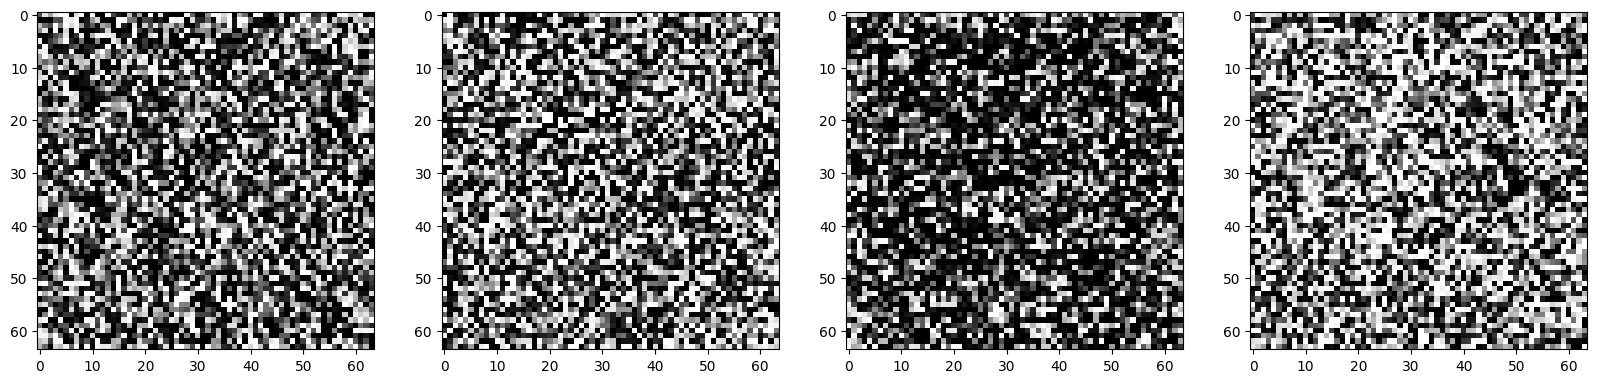

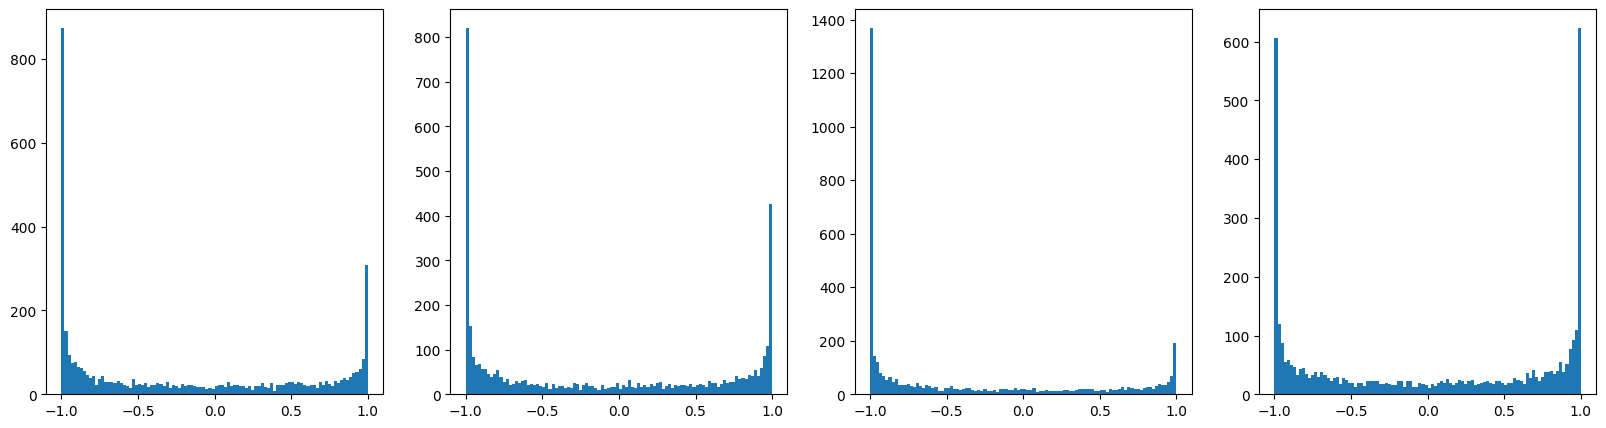

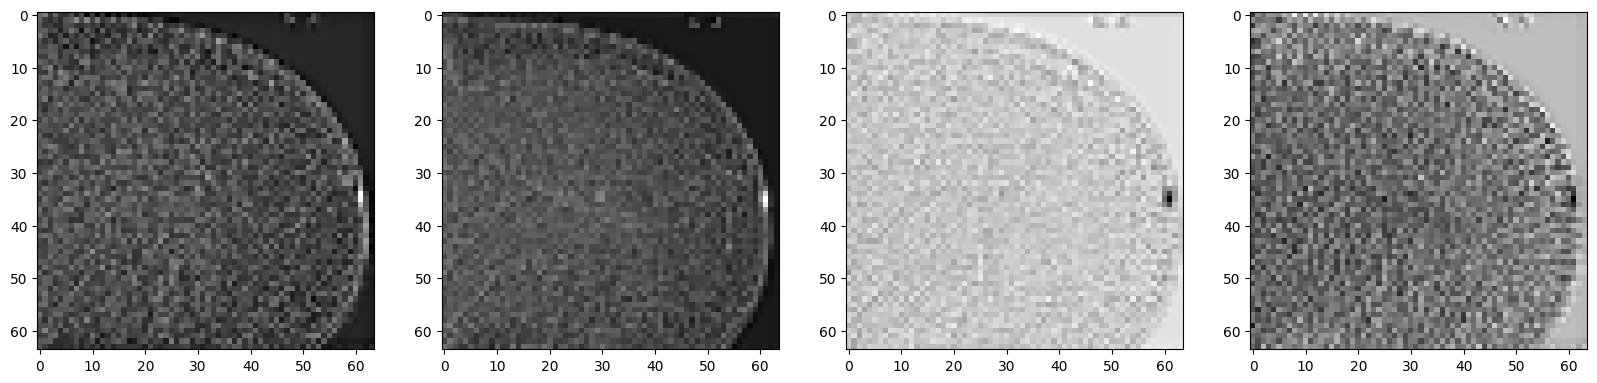

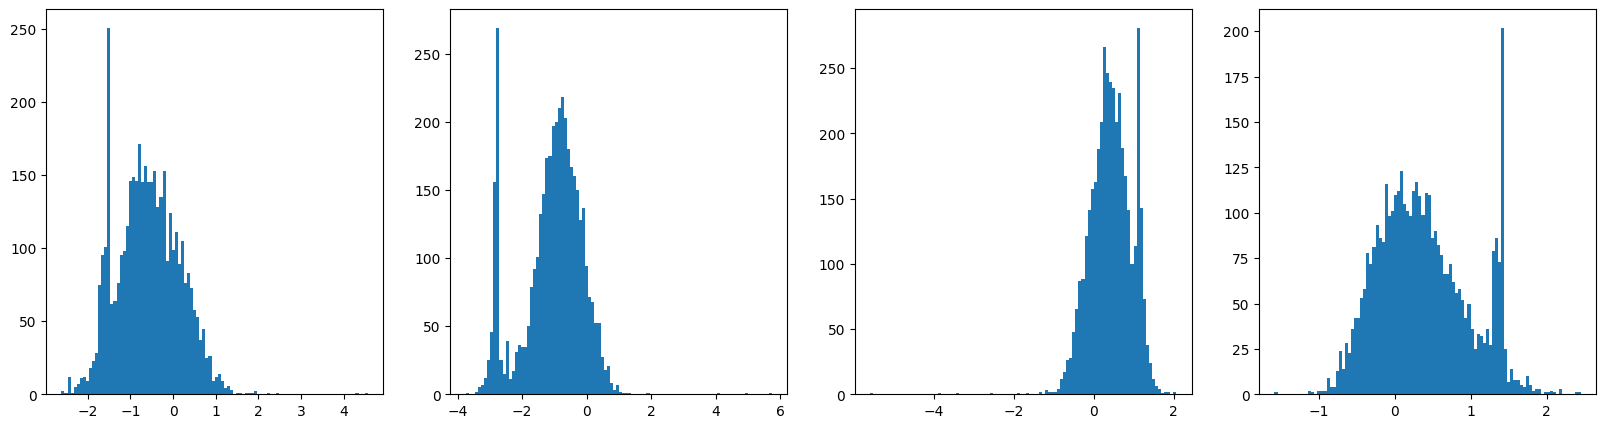

In [13]:
# show the 4 channels
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(latent_inf[0, i].cpu().numpy(), cmap='gray')
# show also historgam
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].hist(latent_inf[0, i].cpu().numpy().flatten(), bins=100)
# show latent space
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(latents[0, i].cpu().numpy(), cmap='gray')
# show also historgam
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].hist(latents[0, i].cpu().numpy().flatten(), bins=100)

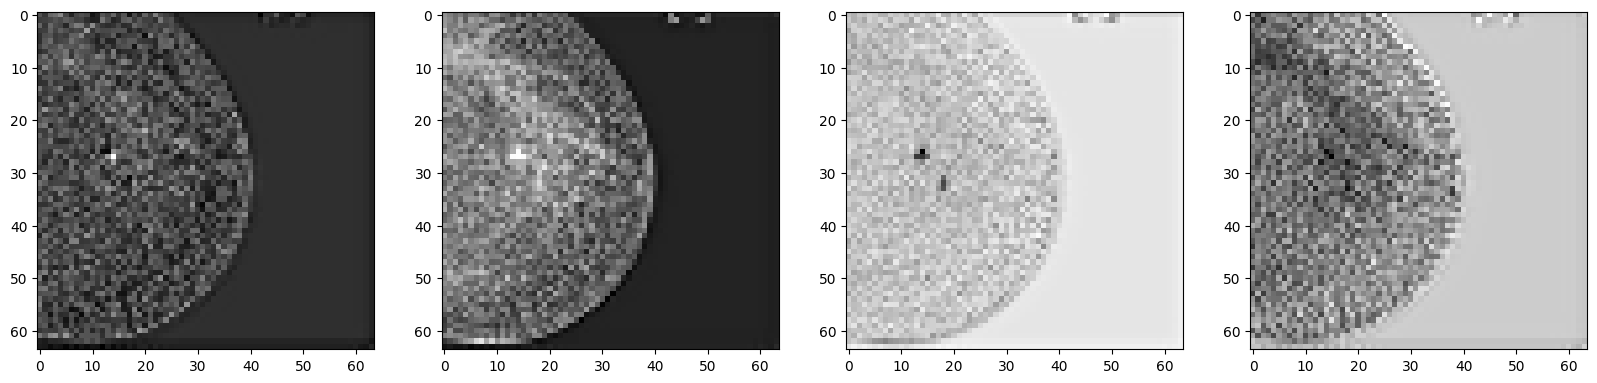

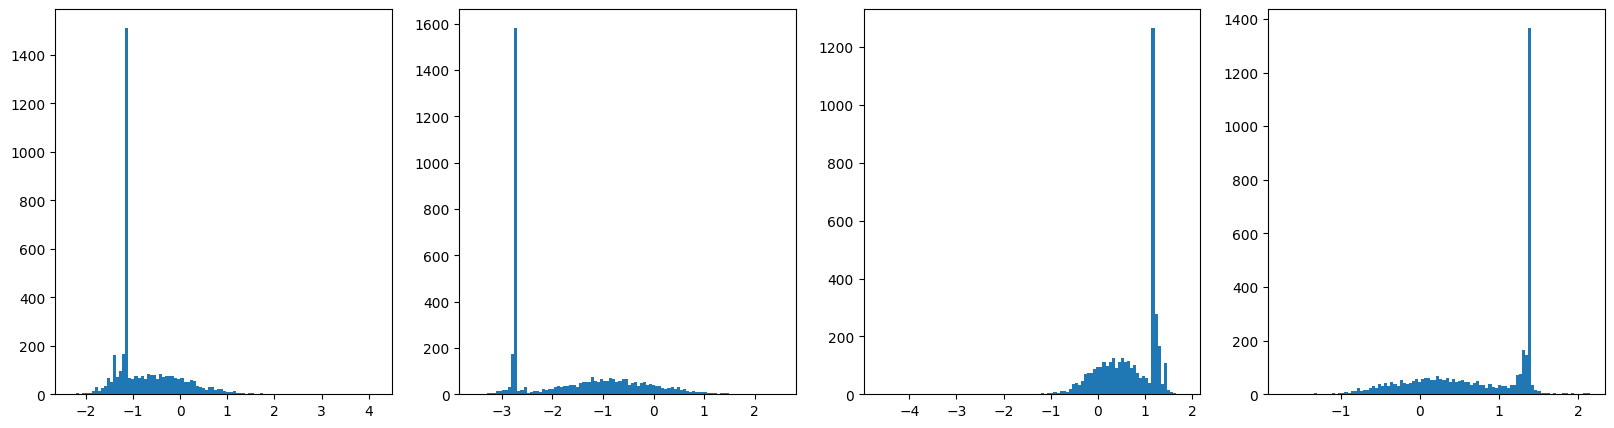

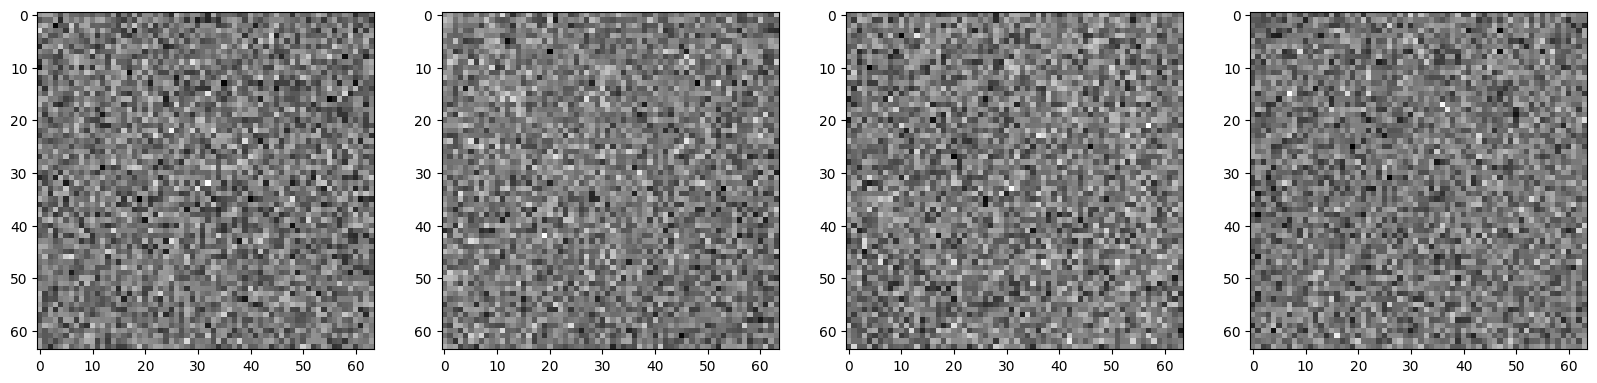

In [14]:
batch_num = 3
# show the 4 channels of the latent
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(latents[batch_num, i].cpu().numpy(), cmap='gray')
# show the histogram of the latent
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].hist(latents[batch_num, i].cpu().numpy().flatten(), bins=100)
# show noisy images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(noisy_images[batch_num, i].cpu().numpy(), cmap='gray')



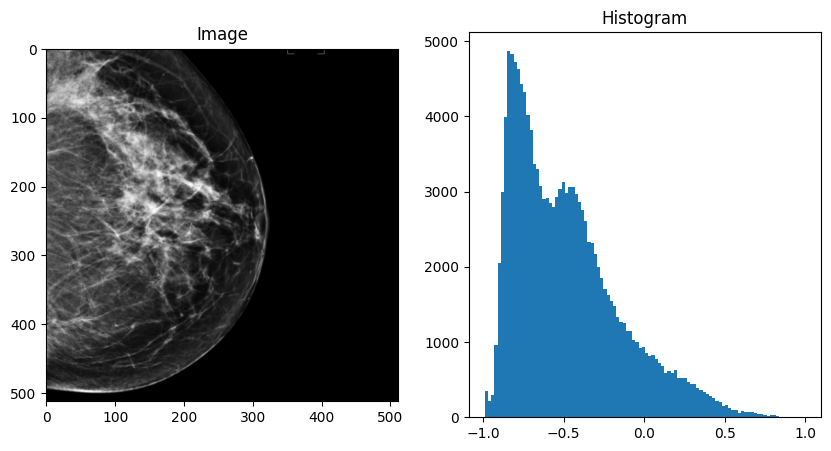

In [15]:
one_channel = batch[batch_num, 0, :, :]
# show image and histogram
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(one_channel.cpu().numpy(), cmap='gray')
ax[0].set_title('Image')
ax[1].hist(one_channel.cpu().numpy().flatten(), bins=100, range=(-0.99, 1))
ax[1].set_title('Histogram')
plt.show()